## CDS 301

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly

In [3]:
def read_csv(file_path):
    return pd.read_csv(open(file_path))

gpu_specs_path = "./data/GPU_Specs.csv"
gpu_scores_path = "./data/GPU_Scores.csv"
gpu_benchmark_path = "./data/GPU_Benchmarks.csv"

df_specs = read_csv(gpu_specs_path)
df_scores = read_csv(gpu_scores_path)
df_benchmarks = read_csv(gpu_benchmark_path)

## Data Previewing

In [4]:
### SIZE OF DATAFRAMES ###
def preview_size(idx, dataframe):
    print(idx,"-",dataframe.shape)

preview_size("Specs", df_specs)
preview_size("Scores", df_scores)
preview_size("Benchmarks", df_benchmarks)

Specs - (3056, 16)
Scores - (1213, 6)
Benchmarks - (2317, 9)


In [5]:
### DATA DICTIONARY ###
def data_dictionary(dataframe):
    new_df = pd.DataFrame({"Column": [], "Type": [], "Missing Data": [], "Percentage Missing": []})
    for column in dataframe.columns:
        new_df.loc[len(new_df)] = {"Column": str(column), "Type": dataframe[column].dtype, "Missing Data": dataframe[column].isna().sum(), "Percentage Missing": round((dataframe[column].isna().sum()/len(dataframe[column])*100), 2)}
    return new_df


In [6]:
data_dictionary(df_specs)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.00
1,productName,object,0,0.00
2,releaseYear,float64,44,1.44
3,memSize,float64,441,14.43
4,memBusWidth,float64,2868,93.85
5,gpuClock,int64,0,0.00
6,memClock,float64,441,14.43
7,unifiedShader,float64,824,26.96
8,tmu,int64,0,0.00
9,rop,int64,0,0.00


In [7]:
data_dictionary(df_scores)

,Column,Type,Missing Data,Percentage Missing
0,Manufacturer,object,0,0.00
1,Device,object,0,0.00
2,CUDA,float64,947,78.07
3,Metal,float64,972,80.13
4,OpenCL,float64,237,19.54
5,Vulkan,float64,584,48.15


In [8]:
data_dictionary(df_benchmarks)

,Column,Type,Missing Data,Percentage Missing
0,gpuName,object,0,0.00
1,G3Dmark,int64,0,0.00
2,G2Dmark,int64,0,0.00
3,price,float64,1764,76.13
4,gpuValue,float64,1764,76.13
5,TDP,float64,1625,70.13
6,powerPerformance,float64,1625,70.13
7,testDate,int64,0,0.00
8,category,object,0,0.00


In [9]:
df_specs.head()

,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
0,NVIDIA,GeForce RTX 5090,2025.0,28.0,448.0,900,1200.0,8192.0,256,128,NaN,NaN,No,PCIe 4.0 x16,HBM2e,Arctic Sound
1,NVIDIA,GeForce RTX 5080,2025.0,16.0,256.0,900,1215.0,6912.0,432,192,NaN,NaN,No,PCIe 4.0 x16,HBM2e,GA100
2,NVIDIA,GeForce RTX 5070,2025.0,12.0,192.0,1825,2000.0,5120.0,320,128,NaN,NaN,No,PCIe 4.0 x16,GDDR6,Navi 21
3,NVIDIA,GeForce RTX 5060 Mobile,2025.0,8.0,128.0,2235,2500.0,4608.0,144,48,NaN,NaN,No,PCIe 5.0 x16,GDDR7,GB206
4,NVIDIA,GeForce RTX 5060,2025.0,8.0,128.0,1825,2250.0,4608.0,288,192,NaN,NaN,No,PCIe 4.0 x16,GDDR6,Navi 31


## Data Cleaning

In [46]:
### Cleaning df_specs ###
df_specs_final = df_specs.drop(columns=["memBusWidth", "pixelShader", "vertexShader"])
df_specs_final = df_specs_final.rename(columns={"productName": "product_name", "releaseYear": "release_year",
                                                "memSize": "memory_size", "gpuClock": "gpu_clock", "memClock": "memory_clock",
                                                "unifiedShader": "unified_shader", "tmu": "texture_mapping_units", "rop": "render_output_units",
                                                "igp": "integrated_graphics_processor", "memType": "memory_type", "gpuChip": "gpu_chip"})
df_specs_final["integrated_graphics_processor"] = df_specs_final["integrated_graphics_processor"].map({"Yes": 1, "No": 0}).astype(bool)
df_specs_final["manufacturer"] = df_specs_final["manufacturer"].str.lower()
df_specs_final["product_name"] = df_specs_final["product_name"].str.lower()
df_specs_final = df_specs_final.dropna(subset=["release_year"])
df_specs_final['memory_size'] = df_specs_final.groupby('release_year')['memory_size'].transform(lambda x: x.fillna(x.median()))
df_specs_final['memory_clock'] = df_specs_final.groupby('release_year')['memory_clock'].transform(lambda x: x.fillna(x.median()))
df_specs_final['unified_shader'] = df_specs_final.groupby('release_year')['unified_shader'].transform(lambda x: x.fillna(x.median()))
df_specs_final['unified_shader'] = df_specs_final.groupby('release_year')['unified_shader'].transform(lambda x: x.fillna(0))
df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)
df_specs_final["memory_type"] = df_specs_final["memory_type"].fillna("None")
data_dictionary(df_specs_final)

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_44808/1867500982.py:15: SyntaxWarning: invalid escape sequence '\s'
  df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)
/tmp/ipykernel_44808/1867500982.py:15: SyntaxWarning: invalid escape sequence '\s'
  df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/co

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,release_year,float64,0,0.0
3,memory_size,float64,0,0.0
4,gpu_clock,int64,0,0.0
5,memory_clock,float64,0,0.0
6,unified_shader,float64,0,0.0
7,texture_mapping_units,int64,0,0.0
8,render_output_units,int64,0,0.0
9,integrated_graphics_processor,bool,0,0.0


In [11]:
df_specs_final.shape

(3012, 13)

In [31]:
for i in range(2000,2025,1):
    print(i, (df_specs_final["release_year"] == i).sum())

2000 32
2001 41
2002 70
2003 120
2004 132
2005 97
2006 129
2007 156
2008 174
2009 106
2010 148
2011 170
2012 173
2013 225
2014 149
2015 165
2016 109
2017 110
2018 93
2019 105
2020 86
2021 88
2022 98
2023 100
2024 21


In [12]:
df_specs_final.head()

,manufacturer,product_name,release_year,memory_size,gpu_clock,memory_clock,unified_shader,texture_mapping_units,render_output_units,integrated_graphics_processor,bus,memory_type,gpu_chip
0,NVIDIA,GeForce RTX 5090,2025.0,28.0,900,1200.0,8192.0,256,128,False,PCIe 4.0 x16,HBM2e,Arctic Sound
1,NVIDIA,GeForce RTX 5080,2025.0,16.0,900,1215.0,6912.0,432,192,False,PCIe 4.0 x16,HBM2e,GA100
2,NVIDIA,GeForce RTX 5070,2025.0,12.0,1825,2000.0,5120.0,320,128,False,PCIe 4.0 x16,GDDR6,Navi 21
3,NVIDIA,GeForce RTX 5060 Mobile,2025.0,8.0,2235,2500.0,4608.0,144,48,False,PCIe 5.0 x16,GDDR7,GB206
4,NVIDIA,GeForce RTX 5060,2025.0,8.0,1825,2250.0,4608.0,288,192,False,PCIe 4.0 x16,GDDR6,Navi 31


In [13]:
df_specs_final[df_specs_final["memory_type"] == "GDDR6"][["manufacturer", "release_year", "memory_clock", "memory_type"]]

,manufacturer,release_year,memory_clock,memory_type
2,NVIDIA,2025.0,2000.0,GDDR6
4,NVIDIA,2025.0,2250.0,GDDR6
5,NVIDIA,2025.0,2000.0,GDDR6
11,NVIDIA,2024.0,2250.0,GDDR6
16,NVIDIA,2024.0,1750.0,GDDR6
...,...,...,...,...
2411,Sony,2005.0,1937.0,GDDR6
2508,Sony,2004.0,1750.0,GDDR6
2522,ATI,2004.0,1250.0,GDDR6
2523,ATI,2004.0,1250.0,GDDR6


In [14]:
df_specs_final["memory_type"].unique()

array(['HBM2e', 'GDDR6', 'GDDR7', 'HBM3e', 'HBM3', 'GDDR6X', 'DDR',
       'HBM2', 'GDDR3', 'DDR2', 'HBM', 'GDDR5X', 'GDDR5', 'LPDDR5',
       'DDR3', 'None', 'SDR', 'DDR4', 'GDDR4', 'eDRAM', 'LPDDR4X', 'SGR',
       'EDO', 'DRAM', 'GDDR2', 'FPM', 'VRAM', 'SGRAM', 'CDRAM'],
      dtype=object)

In [47]:
### Cleaning df_scores ###
df_scores_final = df_scores.copy()
df_scores_final["CUDA"] = df_scores_final["CUDA"].fillna(0)
df_scores_final["Metal"] = df_scores_final["Metal"].fillna(0)
df_scores_final["OpenCL"] = df_scores_final["OpenCL"].fillna(0)
df_scores_final["Vulkan"] = df_scores_final["Vulkan"].fillna(0)
df_scores_final = df_scores_final.rename(columns={"Manufacturer": "manufacturer", "Device": "product_name"})
df_scores_final["manufacturer"] = df_scores_final["manufacturer"].str.lower()
df_scores_final["product_name"] = df_scores_final["product_name"].str.lower()
data_dictionary(df_scores_final)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,CUDA,float64,0,0.0
3,Metal,float64,0,0.0
4,OpenCL,float64,0,0.0
5,Vulkan,float64,0,0.0


In [16]:
(df_scores_final["CUDA"] != 0).sum() / df_scores_final.shape[0] * 100


np.float64(21.929101401483926)

In [17]:
(df_scores_final["Metal"] != 0).sum()/ df_scores_final.shape[0]* 100

np.float64(19.868095630667764)

In [18]:
(df_scores_final["OpenCL"] != 0).sum()/ df_scores_final.shape[0]* 100

np.float64(80.46166529266281)

In [19]:
(df_scores_final["Vulkan"] != 0).sum()/ df_scores_final.shape[0]* 100

np.float64(51.854905193734545)

In [20]:
df_scores_final.shape

(1213, 6)

In [53]:
### Cleaning df_benchmarks ###
df_benchmarks_final = df_benchmarks.copy()
df_benchmarks_final[["manufacturer", "product_name"]] = df_benchmarks_final["gpuName"].str.split(" ", n=1, expand=True)
df_benchmarks_final = df_benchmarks_final.drop(columns=["gpuName", "price", "gpuValue"])
df_benchmarks_final = df_benchmarks_final.rename(columns={"gpuValue": "gpu_value", "powerPerformance": "power_performance", "testDate": "test_date", "TDP": "thermal_design_power"})
df_benchmarks_final = df_benchmarks_final.dropna(subset=["product_name"])
df_benchmarks_final["manufacturer"] = df_benchmarks_final["manufacturer"].str.lower()
df_benchmarks_final["product_name"] = df_benchmarks_final["product_name"].str.lower()
data_dictionary(df_benchmarks_final)

,Column,Type,Missing Data,Percentage Missing
0,G3Dmark,int64,0,0.00
1,G2Dmark,int64,0,0.00
2,thermal_design_power,float64,1595,69.74
3,power_performance,float64,1595,69.74
4,test_date,int64,0,0.00
5,category,object,0,0.00
6,manufacturer,object,0,0.00
7,product_name,object,0,0.00


In [22]:
df_benchmarks_final.head(20)

,G3Dmark,G2Dmark,thermal_design_power,power_performance,test_date,category,manufacturer,product_name
0,29094,1117,450.0,64.650000,2022,Unknown,GeForce,RTX 3090 Ti
1,26887,1031,350.0,76.820000,2021,Desktop,GeForce,RTX 3080 Ti
2,26395,999,350.0,75.410000,2020,Desktop,GeForce,RTX 3090
3,25458,1102,300.0,84.860000,2020,Desktop,Radeon,RX 6900 XT
4,24853,1003,320.0,77.660000,2020,Desktop,GeForce,RTX 3080
5,23367,1003,290.0,80.580000,2021,Desktop,GeForce,RTX 3070 Ti
6,23364,1078,300.0,77.880000,2020,Desktop,Radeon,RX 6800 XT
7,22867,984,230.0,99.420000,2021,Workstation,RTX,A5000
8,22122,832,300.0,73.740000,2021,Workstation,RTX,A6000
9,22093,969,220.0,100.420000,2020,Desktop,GeForce,RTX 3070


In [24]:
df_benchmarks_final.sort_values(by=["year"], ascending=False)

KeyError: 'year'

In [ ]:
df_benchmarks_final.tail(20)

,G3Dmark,G2Dmark,gpu_value,thermal_design_power,power_performance,test_date,category,manufacturer,product_name
2297,3,125,NaN,NaN,NaN,2009,Unknown,VIA/S3G,DeltaChrome IGP
2298,2,58,0.0,NaN,NaN,2012,Unknown,Dell,8100
2299,2,132,NaN,NaN,NaN,2009,Unknown,Intel,82845G Controller
2300,2,136,NaN,NaN,NaN,2009,Unknown,Intel,Extreme Controller
2301,2,43,NaN,NaN,NaN,2012,Unknown,Mobile,Intel 915GM/GMS/910GML Express
2302,2,9,NaN,NaN,NaN,2011,Unknown,Mobile,Intel 945 Express
2303,2,119,NaN,NaN,NaN,2009,Unknown,Quadro,NVS 280 SD
2304,2,89,NaN,NaN,NaN,2010,Unknown,RADEON,IGP 34xM
2305,2,36,NaN,NaN,NaN,2009,Unknown,Radeon,VE
2306,2,147,NaN,NaN,NaN,2009,Unknown,S3,SuperSavage/IXC 1014


In [ ]:
df_benchmarks_final["manufacturer"].unique()

array(['GeForce', 'Radeon', 'RTX', 'TITAN', 'Quadro', 'NVIDIA', 'Tesla',
       'Miracast', 'RadeonT', 'T1200', 'T1000', 'FirePro', 'Ryzen',
       'T600', 'GRID', 'T550', 'EIZO', 'Barco', 'Citrix', 'T400', 'Intel',
       'Custom', 'MONSTER', 'FireStream', 'Matrox', 'Embedded',
       'Qualcomm', 'Seria', 'Firepro', 'TENSOR', 'NVS', 'Mobility',
       'OPAL', 'zxcvIntel', 'Radeon.', '7900', 'FireGL', '3DP',
       'IncrediblE', 'Asus', 'TRINITY', 'Professional', 'SUMO', 'KV',
       'RADEON', 'MCT', 'ASUS', 'HIS', 'PHDGD', 'Mobile', 'CARRIZO', 'GT',
       'A6', 'WinFast', 'VIA/S3G', 'ZX', 'S3', 'EG', 'nForce', 'MOBILITY',
       'All-in-Wonder', 'Extreme', 'RV530', 'FireMV', 'Sapphire', 'XFX',
       'M880G', 'ION', 'MEDION', 'ALL-IN-WONDER', 'M860G', 'Diamond',
       '256MB', '128MB', '128', 'SAPPHIRE', 'Gigabyte', 'GIGABYTE',
       'CONNECT', 'Red', 'OpenXT', '9xx', 'QXL', 'RGH', 'Familia',
       'Master', 'GeCube', 'VIA', 'Famille', 'GeForce4', 'Quadro4',
       '64MB', 'GeForc

In [ ]:
df_benchmarks_final.shape

(2287, 10)

In [ ]:
df_benchmarks_final[["power_performance", "category"]].head(20)

,power_performance,category
0,64.650000,Unknown
1,76.820000,Desktop
2,75.410000,Desktop
3,84.860000,Desktop
4,77.660000,Desktop
5,80.580000,Desktop
6,77.880000,Desktop
7,99.420000,Workstation
8,73.740000,Workstation
9,100.420000,Desktop


In [ ]:
df_benchmarks_final.shape

(2287, 10)

In [57]:
final = pd.merge(df_specs_final, df_scores_final, on=["manufacturer", "product_name"])
# final = pd.merge(final, df_benchmarks_final, on=["manufacturer", "product_name"])

In [58]:
data_dictionary(final)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,release_year,float64,0,0.0
3,memory_size,float64,0,0.0
4,gpu_clock,int64,0,0.0
5,memory_clock,float64,0,0.0
6,unified_shader,float64,0,0.0
7,texture_mapping_units,int64,0,0.0
8,render_output_units,int64,0,0.0
9,integrated_graphics_processor,bool,0,0.0


In [59]:
final.shape

(644, 17)

In [60]:
final["release_year"].unique()

array([2023., 2022., 2021., 2020., 2019., 2018., 2017., 2016., 2015.,
       2014., 2013., 2012., 2011., 2010.])

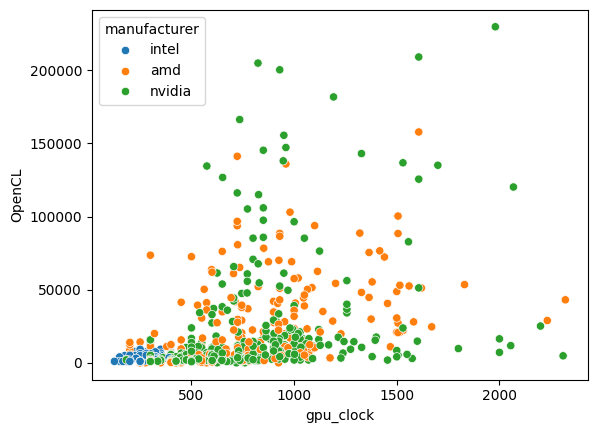

In [61]:
sns.scatterplot(data=final, x="gpu_clock", y="OpenCL", hue="manufacturer")
plt.show()

In [62]:
final["manufacturer"].unique()

array(['intel', 'amd', 'nvidia'], dtype=object)

In [63]:
df_specs_final["manufacturer"].unique()

array(['nvidia', 'amd', 'intel', 'ati', 'sony', 'matrox', 'xgi', '3dfx'],
      dtype=object)

In [64]:
df_scores_final["manufacturer"].unique()

array(['nvidia', 'amd', 'apple', 'qualcomm', 'intel', 'other', 'arm',
       'powervr', 'samsung'], dtype=object)